In [4]:
import gymnasium as gym
import numpy as np
from gymnasium import spaces
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import clear_output, display

# OmokEnv 클래스 정의, gym.Env를 상속받음
class OmokEnv(gym.Env):
    # 환경 메타데이터 정의, human 렌더 모드와 30fps 설정
    metadata = {"render_modes": ["human"], "render_fps": 30}

    # 초기화 함수, n과 k는 각각 보드 크기와 승리 조건
    def __init__(self, n=10, k=5):
        super(OmokEnv, self).__init__()
        self.n = n  # 보드 크기 설정
        self.k = k  # 승리 조건 설정
        # 행동 공간 정의, 보드의 각 위치에 돌을 놓는 것을 의미 (0부터 n*n-1까지의 값)
        self.action_space = spaces.Discrete(n * n)
        # 관찰 공간 정의, 보드는 n*n 크기의 배열로 표현되며 값은 0, 1, 2 (빈 칸, 플레이어 1, 플레이어 2)
        self.observation_space = spaces.Box(low=0, high=2, shape=(n, n), dtype=int)
        self.state = np.zeros((n, n), dtype=int)  # 초기 상태는 빈 보드
        self.current_player = 1  # 플레이어 1이 먼저 시작
        self.seed()  # 시드 설정
        self.window = None  # 렌더링 창 초기화
        self.ax = None  # 렌더링 축 초기화

    # 시드 설정 함수, 난수 생성을 위해 사용
    def seed(self, seed=None):
        self.np_random, seed = gym.utils.seeding.np_random(seed)
        return [seed]

    # 환경 리셋 함수, 게임을 초기 상태로 되돌림
    def reset(self, seed=None, options=None):
        if seed is not None:
            self.seed(seed)  # 시드 설정
        self.state = np.zeros((self.n, self.n), dtype=int)  # 보드를 빈 상태로 초기화
        self.current_player = 1  # 플레이어 1이 먼저 시작
        return self.state, {}  # 상태와 빈 딕셔너리 반환

    # 한 스텝 진행 함수, 액션을 받아서 보드 상태를 업데이트
    def step(self, action):
        row, col = divmod(action, self.n)  # 액션을 보드의 행과 열로 변환
        if self.state[row, col] != 0:  # 해당 위치가 비어있지 않으면
            return self.state, -10, True, False, {}  # 잘못된 움직임, 큰 패널티와 함께 에피소드 종료
        self.state[row, col] = self.current_player  # 현재 플레이어의 돌을 놓음
        winner = self.check_winner()  # 승자 체크
        if winner:  # 승자가 있으면
            return self.state, 1, True, False, {}  # 승자가 승리, 에피소드 종료
        elif np.all(self.state != 0):  # 보드가 꽉 찬 경우
            return self.state, 0, True, False, {}  # 무승부, 에피소드 종료
        self.current_player = 3 - self.current_player  # 플레이어 교체
        return self.state, 0, False, False, {}  # 게임 계속 진행

    # 승자 체크 함수
    def check_winner(self):
        for row in range(self.n):
            for col in range(self.n):
                if self.state[row, col] == 0:  # 빈 칸은 무시
                    continue
                # 각 방향으로 k개의 돌이 연속으로 놓였는지 확인
                if self.check_direction(row, col, 1, 0) or \
                   self.check_direction(row, col, 0, 1) or \
                   self.check_direction(row, col, 1, 1) or \
                   self.check_direction(row, col, 1, -1):
                    return self.state[row, col]  # 현재 플레이어가 승리
        return 0  # 승자가 없음

    # 특정 방향으로 k개의 돌이 연속으로 놓였는지 확인하는 함수
    def check_direction(self, row, col, drow, dcol):
        count = 0
        player = self.state[row, col]
        for i in range(self.k):
            r, c = row + i * drow, col + i * dcol
            if 0 <= r < self.n and 0 <= c < self.n and self.state[r, c] == player:
                count += 1
            else:
                break
        return count == self.k

    # 보드 상태를 렌더링하는 함수
    def render(self, mode='human'):
        clear_output(wait=True)  # 출력 창을 지움
        plt.figure(figsize=(7, 7))  # 그림 크기 설정
        ax = plt.gca()  # 현재 그림의 축을 가져옴
        ax.set_xlim(-1, self.n)  # x축 범위 설정
        ax.set_ylim(-1, self.n)  # y축 범위 설정
        ax.set_xticks(np.arange(-0.5, self.n, 1))  # x축 눈금 설정
        ax.set_yticks(np.arange(-0.5, self.n, 1))  # y축 눈금 설정
        ax.grid(True)  # 그리드 표시
        ax.set_xticklabels([])  # x축 눈금 라벨 제거
        ax.set_yticklabels([])  # y축 눈금 라벨 제거

        # 보드 상태에 따라 돌을 그려줌
        for row in range(self.n):
            for col in range(self.n):
                if self.state[row, col] == 1:
                    ax.add_patch(patches.Circle((col, self.n - 1 - row), 0.4, color='black'))
                elif self.state[row, col] == 2:
                    ax.add_patch(patches.Circle((col, self.n - 1 - row), 0.4, color='red'))

        plt.draw()  # 그림을 그려줌
        display(plt.gcf())  # 그림을 출력
        plt.close()  # 현재 그림을 닫음

    # 환경을 닫는 함수
    def close(self):
        if self.window is not None:
            plt.close(self.window)  # 창을 닫음
            self.window = None

# 보드 크기와 승리 조건을 위한 전역 변수
n = 10
k = 5
start = '-' * (n * n)


In [5]:
from math import sqrt, log
import random

class Node():
    def __init__(self, state, player=None, pos=None, parent=None):
        self.state = state
        self.player = player
        self.pos = pos
        self.parent = parent
        self.nwin = 0
        self.nvisit = 0
        self.untried = get_empty(state)
        self.children = []

    def UCTselect(self):
        s = sorted(self.children, key=lambda c: c.nwin / c.nvisit + sqrt(log(self.nvisit) / c.nvisit))
        return s[-1]

    def makeChild(self, state, pos, player):
        node = Node(state, player, pos, parent=self)
        self.untried.remove(pos)
        self.children.append(node)
        return node

    def update(self, winner):
        self.nvisit += 1
        if winner == 'T':  # Draw
            self.nwin += 0.5
        elif winner == self.player:
            self.nwin += 1

    def __repr__(self):
        return str(self.state) + " " + str(self.nwin) + "/" + str(self.nvisit)

def randomAroundCenter(n):
    c = n * (n // 2) + n // 2
    return random.choice([c, c - 1, c + 1, c - n, c + n])

def Move(state, pos, player):
    return state[:pos] + player + state[pos + 1:]

def switch_player(player):
    return 'X' if player == 'O' else 'O'

def get_empty(state):
    if decide_winner(state) in ['O', 'X', 'T']:  # If a winner is determined
        return []

    empty = []
    for i in range(len(state)):
        if state[i] != '-': continue
        r, c = i // n, i % n
        for (y, x) in [(r - 1, c - 1), (r - 1, c), (r - 1, c + 1), (r, c - 1), (r, c + 1), (r + 1, c - 1), (r + 1, c), (r + 1, c + 1)]:
            if 0 <= y <= n - 1 and 0 <= x <= n - 1 and state[y * n + x] == '-' and y * n + x not in empty:
                empty.append(y * n + x)
    return empty

def decide_winner(state):
    nvoid = 0
    for i in range(n * n):
        s = state[i]
        if s == '-':
            nvoid += 1
            continue

        r, c = i // n, i % n

        c1, c2 = c - 1, c + 1
        while c1 >= 0 and state[r * n + c1] == s: c1 -= 1
        while c2 <= n - 1 and state[r * n + c2] == s: c2 += 1
        if c2 - c1 - 1 == k: return s

        r1, r2 = r - 1, r + 1
        while r1 >= 0 and state[r1 * n + c] == s: r1 -= 1
        while r2 <= n - 1 and state[r2 * n + c] == s: r2 += 1
        if r2 - r1 - 1 == k: return s

        r1, c1, r2, c2 = r - 1, c - 1, r + 1, c + 1
        while r1 >= 0 and c1 >= 0 and state[r1 * n + c1] == s: r1, c1 = r1 - 1, c1 - 1
        while r2 <= n - 1 and c2 <= n - 1 and state[r2 * n + c2] == s: r2, c2 = r2 + 1, c2 + 1
        if r2 - r1 - 1 == k: return s

        r1, c1, r2, c2 = r - 1, c + 1, r + 1, c - 1
        while r1 >= 0 and c1 <= n - 1 and state[r1 * n + c1] == s: r1, c1 = r1 - 1, c1 + 1
        while r2 <= n - 1 and c2 >= 0 and state[r2 * n + c2] == s: r2, c2 = r2 + 1, c2 - 1
        if r2 - r1 - 1 == k: return s

    if nvoid == 0: return 'T'  # Tie
    return 'N'  # No winner yet

def mcts(state, player):
    root = Node(state)

    for i in range(10000):
        node = root
        state = node.state
        roll_player = player
        while node.untried == [] and node.children != []:  # Select
            node = node.UCTselect()
            state = Move(state, node.pos, roll_player)
            roll_player = switch_player(roll_player)

        if node.untried != []:  # Expand
            pos = random.choice(node.untried)
            state = Move(state, pos, roll_player)
            node = node.makeChild(state, pos, roll_player)
            roll_player = switch_player(roll_player)

        while True:  # Simulate
            e = get_empty(state)
            if e == []: break
            state = Move(state, random.choice(e), roll_player)
            roll_player = switch_player(roll_player)

        winner = decide_winner(state)  # Backpropagate
        while node != None:
            node.update(winner)
            node = node.parent

    return sorted(root.children, key=lambda c: c.nwin / c.nvisit)[-1].pos


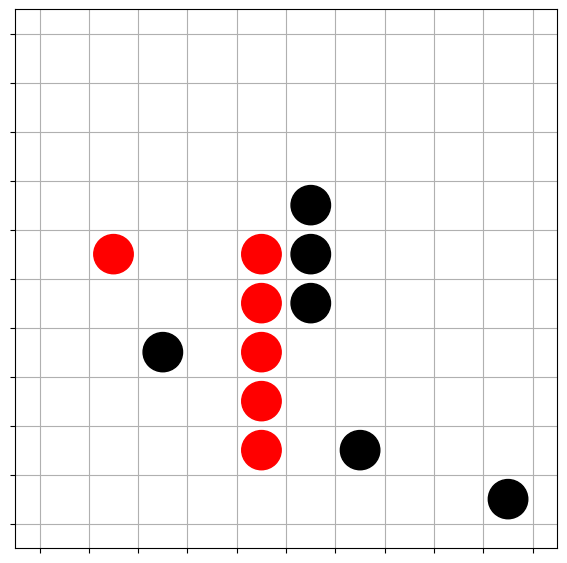

Player 1 wins!


In [7]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env

# matplotlib 플롯을 인라인으로 표시하도록 설정
%matplotlib inline

# 환경 생성
env = OmokEnv()

# 환경 체크 (환경이 Gym의 요구사항을 충족하는지 확인)
check_env(env)

# PPO 에이전트 생성 및 학습
agent1 = PPO('MlpPolicy', env, verbose=1)
agent1.learn(total_timesteps=500000)  # 50만 타임스텝 동안 학습
agent1.save("ppo_omok_agent1")  # 학습된 에이전트 저장

# 저장된 PPO 에이전트 로드
agent1 = PPO.load("ppo_omok_agent1")

# 게임 플레이 함수
def play_game():
    state, _ = env.reset()  # 환경 초기화 및 상태 초기화
    env.render()  # 현재 보드 상태 렌더링
    done = False  # 게임 종료 여부 플래그
    while not done:
        if env.current_player == 1:  # 현재 플레이어가 에이전트 1인 경우
            action, _ = agent1.predict(state, deterministic=True)  # 에이전트 1이 액션 예측
            state, reward, done, truncated, _ = env.step(action)  # 예측한 액션으로 환경을 한 스텝 진행
        else:  # 현재 플레이어가 MCTS인 경우
            state_str = ''.join(map(str, state.flatten())).replace('0', '-').replace('1', 'X').replace('2', 'O')
            if state_str == '-' * n * n:  # 첫 번째 수인 경우
                action = randomAroundCenter(n)  # 중앙 근처의 무작위 위치 선택
            else:
                action = mcts(state_str, 'O')  # MCTS를 사용하여 액션 선택
            row, col = divmod(action, n)  # 선택한 액션을 보드의 행과 열로 변환
            state, reward, done, truncated, _ = env.step(row * n + col)  # 선택한 위치로 환경을 한 스텝 진행
        
        env.render()  # 현재 보드 상태 렌더링
    
    if reward == 1:  # 에이전트 1이 승리한 경우
        print(f"Player {3 - env.current_player} wins!")
    else:  # 무승부인 경우
        print("It's a tie!")

# 게임 플레이 함수 호출
play_game()
